In [2]:
import os, sys
# Add repo root so Python sees models/ & util/
repo_root = os.path.abspath(".")
if repo_root not in sys.path:
    sys.path.insert(0, repo_root)

print("🛠 Repo root added:", repo_root)
print("models folder exists:", os.path.isdir(os.path.join(repo_root, "models")))
print("GroundingDINO folder exists:", os.path.isdir(os.path.join(repo_root, "models", "GroundingDINO")))
print("GroundingDINO files:", os.listdir(os.path.join(repo_root, "models", "GroundingDINO")))

from models import build_groundingdino
print("✅ Imported build_groundingdino successfully")


🛠 Repo root added: /isis/home/hasana3/Open-GroundingDino
models folder exists: True
GroundingDINO folder exists: True
GroundingDINO files: ['csrc', 'utils.py', 'backbone', '__pycache__', 'transformer.py', 'ms_deform_attn.py', 'bertwarper.py', 'ops', 'matcher.py', '__init__.py', 'transformer_vanilla.py', 'groundingdino.py', 'fuse_modules.py']
✅ Imported build_groundingdino successfully


/isis/home/hasana3/miniconda3/envs/dino_train/lib/python3.10/site-packages/timm/models/layers/__init__.py:48: FutureWarning: Importing from timm.models.layers is deprecated, please import via timm.layers
  warnings.warn(f"Importing from {__name__} is deprecated, please import via timm.layers", FutureWarning)


In [3]:
import os
import torch
from util.slconfig import SLConfig
from util.utils import clean_state_dict, to_device
from models import build_model
from models.GroundingDINO import build_groundingdino


def build_model(args):
    return build_groundingdino(args)

# --- 1️⃣  Config & pretrained weight paths ---
cfg_path = "config/GroundingDINO_SwinB_cfg.py"
pretrain_path = "../vlmtest/GroundingDINO/weights/groundingdino_swinb_cogcoor.pth"

# --- 2️⃣  Load config ---
args = SLConfig.fromfile(cfg_path)
args.device = "cuda" if torch.cuda.is_available() else "cpu"

args.use_coco_eval = False     # skip COCO API dependency
args.coco_val_path = None      # prevent missing attribute error


# --- 3️⃣  Build model & criterion ---
model, criterion, postprocessors = build_model(args)
print("✅ Model + Criterion built")

# --- 4️⃣  Load pretrained weights (ignore missing keys safely) ---
if os.path.exists(pretrain_path):
    ckpt = torch.load(pretrain_path, map_location="cpu")
    if "model" in ckpt:
        model.load_state_dict(clean_state_dict(ckpt["model"]), strict=False)
    else:
        model.load_state_dict(clean_state_dict(ckpt), strict=False)
    print(f"✅ Loaded pretrained weights from {pretrain_path}")
else:
    print("⚠️ Pretrained weights not found — continuing without them.")

model = model.to(args.device)
criterion = criterion.to(args.device)
model.eval()


/isis/home/hasana3/miniconda3/envs/dino_train/lib/python3.10/site-packages/torch/functional.py:504: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3190.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


final text_encoder_type: bert-base-uncased
load tokenizer done.


/isis/home/hasana3/miniconda3/envs/dino_train/lib/python3.10/site-packages/huggingface_hub/file_download.py:945: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


final text_encoder_type: bert-base-uncased
load tokenizer done.
✅ Model + Criterion built
✅ Loaded pretrained weights from ../vlmtest/GroundingDINO/weights/groundingdino_swinb_cogcoor.pth


GroundingDINO(
  (transformer): Transformer(
    (encoder): TransformerEncoder(
      (layers): ModuleList(
        (0): DeformableTransformerEncoderLayer(
          (self_attn): MultiScaleDeformableAttention(
            (sampling_offsets): Linear(in_features=256, out_features=256, bias=True)
            (attention_weights): Linear(in_features=256, out_features=128, bias=True)
            (value_proj): Linear(in_features=256, out_features=256, bias=True)
            (output_proj): Linear(in_features=256, out_features=256, bias=True)
          )
          (dropout1): Dropout(p=0.0, inplace=False)
          (norm1): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
          (linear1): Linear(in_features=256, out_features=2048, bias=True)
          (dropout2): Dropout(p=0.0, inplace=False)
          (linear2): Linear(in_features=2048, out_features=256, bias=True)
          (dropout3): Dropout(p=0.0, inplace=False)
          (norm2): LayerNorm((256,), eps=1e-05, elementwise_affine=Tr

In [4]:
from util.misc import NestedTensor

# --- Dummy batch (1 image, 384×384 RGB) ---
images = torch.rand(1, 3, 384, 384).to(args.device)
masks = torch.zeros(1, 384, 384, dtype=torch.bool).to(args.device)
samples = NestedTensor(images, masks)

# --- Captions ---
captions = ["car . pedestrian ."]
cap_list = [["car", "pedestrian"]]

# --- Fake GT targets ---
targets = [{
    "boxes": torch.tensor([[0.2, 0.3, 0.4, 0.5]], device=args.device),  # xywh normalized
    "labels": torch.tensor([1], device=args.device),
    "orig_size": torch.tensor([384, 384], device=args.device)
}]

# --- Forward + loss ---
with torch.no_grad():
    outputs = model(samples, captions=captions)
    loss_dict = criterion(outputs, targets, cap_list, captions)

print("🔍 Loss keys:", list(loss_dict.keys()))

for k, v in loss_dict.items():
    if torch.is_tensor(v):
        print(f"{k:25s} : {v.item():.6f}")

# --- Weighted total ---
losses = sum(
    loss_dict[k] * criterion.weight_dict[k]
    for k in loss_dict.keys()
    if k in criterion.weight_dict
)
print("\n🧮 Total weighted loss:", losses.item())

# --- Check any missing/misaligned terms ---
missing_keys = [k for k in loss_dict if k not in criterion.weight_dict]
extra_keys = [k for k in criterion.weight_dict if k not in loss_dict]
print("\n❓Missing in weight_dict:", missing_keys)
print("❓Extra in weight_dict:", extra_keys)


/isis/home/hasana3/miniconda3/envs/dino_train/lib/python3.10/site-packages/transformers/modeling_utils.py:962: FutureWarning: The `device` argument is deprecated and will be removed in v5 of Transformers.
  warnings.warn(


🔍 Loss keys: ['loss_ce', 'loss_bbox', 'loss_giou', 'loss_xy', 'loss_hw', 'loss_ce_0', 'loss_bbox_0', 'loss_giou_0', 'loss_xy_0', 'loss_hw_0', 'loss_ce_1', 'loss_bbox_1', 'loss_giou_1', 'loss_xy_1', 'loss_hw_1', 'loss_ce_2', 'loss_bbox_2', 'loss_giou_2', 'loss_xy_2', 'loss_hw_2', 'loss_ce_3', 'loss_bbox_3', 'loss_giou_3', 'loss_xy_3', 'loss_hw_3', 'loss_ce_4', 'loss_bbox_4', 'loss_giou_4', 'loss_xy_4', 'loss_hw_4', 'loss_ce_interm', 'loss_bbox_interm', 'loss_giou_interm', 'loss_xy_interm', 'loss_hw_interm']
loss_ce                   : 0.907616
loss_bbox                 : 0.154271
loss_giou                 : 0.243625
loss_xy                   : 0.019262
loss_hw                   : 0.135008
loss_ce_0                 : 0.989710
loss_bbox_0               : 0.100396
loss_giou_0               : 0.169700
loss_xy_0                 : 0.008031
loss_hw_0                 : 0.092365
loss_ce_1                 : 1.034398
loss_bbox_1               : 0.100517
loss_giou_1               : 0.152115
loss_xy

/isis/home/hasana3/miniconda3/envs/dino_train/lib/python3.10/site-packages/torch/utils/checkpoint.py:31: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn("None of the inputs have requires_grad=True. Gradients will be None")


In [5]:
# Gradient check
for p in model.parameters():
    if p.grad is not None:
        p.grad.zero_()

images.requires_grad_()  # enable gradient tracking

outputs = model(samples, captions=captions)
loss_dict = criterion(outputs, targets, cap_list, captions)
loss = sum(loss_dict[k] * criterion.weight_dict.get(k, 0.0) for k in loss_dict)
loss.backward()

for name, param in model.named_parameters():
    if param.grad is not None and torch.isnan(param.grad).any():
        print(f"❌ NaN gradient in {name}")
    elif param.grad is not None:
        print(f"{name:60s} grad mean: {param.grad.mean().item():.3e}")
        break  # just sample a few


transformer.level_embed                                      grad mean: 9.230e-03


In [6]:
import json
from datasets import build_dataset
from torch.utils.data import DataLoader

# --- 1️⃣ Load the JSON ---
with open("dataset_meta_kitti.json", "r") as f:
    dataset_meta = json.load(f)

# Pick the training dataset (first element of the list)
datasetinfo = dataset_meta["train"][0]
print("Dataset mode:", datasetinfo["dataset_mode"])

args.fix_size = None  # or False if the dataset code expects a boolean


# --- 2️⃣ Build the dataset ---
dataset = build_dataset("train", args, datasetinfo)
print("✅ Dataset built successfully with", len(dataset), "samples")

def collate_odvg(batch):
    # remove None samples (in case of bad entries)
    batch = [b for b in batch if b is not None]
    images, targets = zip(*batch)
    return list(images), list(targets)


# --- 3️⃣ Build DataLoader ---
data_loader = DataLoader(
    dataset,
    batch_size=2,
    shuffle=False,
    num_workers=2,
    collate_fn=collate_odvg
)
print("✅ DataLoader ready.")


Dataset mode: odvg
../vlmtest/GroundingDINO/dataset/kitti/training/image_02 ../vlmtest/GroundingDINO/dataset/kitti/training/train_grounding_fixed.jsonl None
  == total images: 4520
✅ Dataset built successfully with 4520 samples
✅ DataLoader ready.


In [7]:
samples, targets = next(iter(data_loader))

print("Number of samples in batch:", len(samples))
print("Example caption:", targets[0]["caption"])
print("Caption tokens:", targets[0]["cap_list"])
print("GT boxes shape:", targets[0]["boxes"].shape)
print("GT labels:", targets[0]["labels"])


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


Number of samples in batch: 2
Example caption: pedestrian . car .
Caption tokens: ['pedestrian', 'car']
GT boxes shape: torch.Size([2, 4])
GT labels: tensor([0, 0])


In [ ]:
from util.misc import nested_tensor_from_tensor_list

# samples is still a tuple of images here
samples_list, targets = next(iter(data_loader))

# Convert tuple → NestedTensor
samples = nested_tensor_from_tensor_list(samples_list)

# Now move it to device
samples = samples.to(args.device)

# Extract captions + cap lists
captions = [t["caption"] for t in targets]
cap_list = [t["cap_list"] for t in targets]

# Move tensor parts of targets to device
targets = [
    {k: v.to(args.device) for k, v in t.items() if torch.is_tensor(v)}
    for t in targets
]

# --- Forward + Loss ---
with torch.no_grad():
    outputs = model(samples, captions=captions)

    # Copy bbox weights to xy/hw terms
    for k, v in list(criterion.weight_dict.items()):
        if k.startswith("loss_bbox"):
            criterion.weight_dict[k.replace("bbox", "xy")] = v
            criterion.weight_dict[k.replace("bbox", "hw")] = v

    loss_dict = criterion(outputs, targets, cap_list, captions)

# --- Print losses ---
print("🔍 Loss keys:", list(loss_dict.keys()))
for k, v in loss_dict.items():
    if torch.is_tensor(v):
        print(f"{k:25s}: {v.item():.6f}")

# --- Weighted total ---
losses = sum(
    loss_dict[k] * criterion.weight_dict[k]
    for k in loss_dict.keys()
    if k in criterion.weight_dict
)
print("\n🧮 Total weighted loss:", losses.item())

# --- Consistency check ---
missing_keys = [k for k in loss_dict if k not in criterion.weight_dict]
extra_keys = [k for k in criterion.weight_dict if k not in loss_dict]
print("\n❓Missing in weight_dict:", missing_keys)
print("❓Extra in weight_dict:", extra_keys)

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


🔍 Loss keys: ['loss_ce', 'loss_bbox', 'loss_giou', 'loss_xy', 'loss_hw', 'loss_ce_0', 'loss_bbox_0', 'loss_giou_0', 'loss_xy_0', 'loss_hw_0', 'loss_ce_1', 'loss_bbox_1', 'loss_giou_1', 'loss_xy_1', 'loss_hw_1', 'loss_ce_2', 'loss_bbox_2', 'loss_giou_2', 'loss_xy_2', 'loss_hw_2', 'loss_ce_3', 'loss_bbox_3', 'loss_giou_3', 'loss_xy_3', 'loss_hw_3', 'loss_ce_4', 'loss_bbox_4', 'loss_giou_4', 'loss_xy_4', 'loss_hw_4', 'loss_ce_interm', 'loss_bbox_interm', 'loss_giou_interm', 'loss_xy_interm', 'loss_hw_interm']
loss_ce                  : 0.008133
loss_bbox                : 0.125978
loss_giou                : 0.287292
loss_xy                  : 0.012449
loss_hw                  : 0.113530
loss_ce_0                : 0.595510
loss_bbox_0              : 0.055837
loss_giou_0              : 0.132263
loss_xy_0                : 0.012722
loss_hw_0                : 0.043115
loss_ce_1                : 0.645019
loss_bbox_1              : 0.052019
loss_giou_1              : 0.121052
loss_xy_1           

In [ ]:
samples, targets = next(iter(data_loader))
print(targets[0].keys())


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


dict_keys(['size', 'cap_list', 'caption', 'boxes', 'labels'])


In [ ]:
import numpy as np
from tqdm import tqdm

model.train()
losses = []

for i, (samples_list, targets) in enumerate(tqdm(data_loader, total=10)):
    if i >= 10:
        break
    samples = nested_tensor_from_tensor_list(samples_list).to(args.device)
    captions = [t["caption"] for t in targets]
    cap_list = [t["cap_list"] for t in targets]
    targets = [{k: v.to(args.device) for k, v in t.items() if torch.is_tensor(v)} for t in targets]

    optimizer.zero_grad()
    outputs = model(samples, captions=captions)
    loss_dict = criterion(outputs, targets, cap_list, captions)
    total_loss = sum(loss_dict[k] * criterion.weight_dict[k] for k in loss_dict if k in criterion.weight_dict)
    total_loss.backward()
    optimizer.step()

    losses.append(total_loss.item())
    print(f"Batch {i}: loss={total_loss.item():.4f}")

print(f"\n📉 Mean loss over 10 batches: {np.mean(losses):.4f}")


 10%|█         | 1/10 [00:01<00:11,  1.23s/it]

Batch 0: loss=6.4161


 20%|██        | 2/10 [00:01<00:07,  1.12it/s]

Batch 1: loss=7.2295


 30%|███       | 3/10 [00:02<00:05,  1.20it/s]

Batch 2: loss=11.7551


 40%|████      | 4/10 [00:03<00:04,  1.26it/s]

Batch 3: loss=7.8508


 50%|█████     | 5/10 [00:03<00:03,  1.45it/s]

Batch 4: loss=8.6800


 60%|██████    | 6/10 [00:04<00:02,  1.39it/s]

Batch 5: loss=3.5830


 70%|███████   | 7/10 [00:05<00:02,  1.35it/s]

Batch 6: loss=6.2835


 80%|████████  | 8/10 [00:06<00:01,  1.37it/s]

Batch 7: loss=6.3456


 90%|█████████ | 9/10 [00:06<00:00,  1.38it/s]

Batch 8: loss=4.8641


100%|██████████| 10/10 [00:07<00:00,  1.30it/s]

Batch 9: loss=3.2326


100%|██████████| 10/10 [00:07<00:00,  1.26it/s]


📉 Mean loss over 10 batches: 6.6240


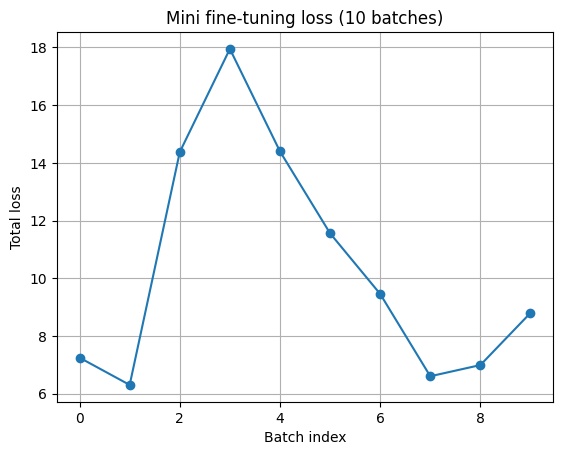

In [ ]:
import matplotlib.pyplot as plt
plt.plot(losses, marker='o')
plt.title("Mini fine-tuning loss (10 batches)")
plt.xlabel("Batch index")
plt.ylabel("Total loss")
plt.grid(True)
plt.show()


In [29]:
import matplotlib.pyplot as plt
import torchvision.transforms.functional as F
import torch, random
from util.misc import nested_tensor_from_tensor_list

# ImageNet normalization used by most backbones
_IMAGENET_MEAN = torch.tensor([0.485, 0.456, 0.406]).view(3,1,1)
_IMAGENET_STD  = torch.tensor([0.229, 0.224, 0.225]).view(3,1,1)

def _denormalize(img_chw: torch.Tensor) -> torch.Tensor:
    """img_chw: float CHW in ImageNet norm -> float CHW in [0,1]"""
    img = img_chw.detach().cpu().float()
    img = img * _IMAGENET_STD + _IMAGENET_MEAN
    return img.clamp(0, 1)

def _to_pil(img_chw_01: torch.Tensor):
    """float CHW in [0,1] -> PIL"""
    return F.to_pil_image((img_chw_01 * 255).byte())

def _gt_center_xywh_norm_to_xyxy_px(boxes_norm: torch.Tensor, H: int, W: int) -> torch.Tensor:
    """boxes_norm: [N,4] with (xc,yc,w,h) in [0,1] -> xyxy pixels [N,4]"""
    if boxes_norm.numel() == 0:
        return boxes_norm.new_zeros((0,4))
    xc = boxes_norm[:, 0] * W
    yc = boxes_norm[:, 1] * H
    ww = boxes_norm[:, 2] * W
    hh = boxes_norm[:, 3] * H
    x1 = xc - ww/2
    y1 = yc - hh/2
    x2 = xc + ww/2
    y2 = yc + hh/2
    return torch.stack([x1, y1, x2, y2], dim=1)

def visualize_detections(model, postprocessors, dataset, num_samples=10, device="cuda",
                         conf_thresh=0.3, seed=None):
    """
    - Shows GT (green) and predictions (red) on num_samples random images.
    - If a frame has no GT, it still renders with 'No GT available'.
    """
    model.eval()
    rng = random.Random(seed)
    indices = rng.sample(range(len(dataset)), min(num_samples, len(dataset)))

    for idx in indices:
        # ---- fetch one sample
        sample, target = dataset[idx]

        # original normalized tensor for model input
        if hasattr(sample, "tensors"):      # NestedTensor-like
            img_chw_norm = sample.tensors[0]
        else:                               # raw CHW tensor
            img_chw_norm = sample

        # infer H,W for post-process (prefer target if given)
        if "orig_size" in target:
            H, W = target["orig_size"].tolist()
        elif "size" in target:
            H, W = target["size"].tolist()
        else:
            _, H, W = img_chw_norm.shape

        # ---- prepare model input (DO NOT denormalize here)
        model_input = nested_tensor_from_tensor_list([img_chw_norm]).to(device)
        captions = [target.get("caption", "car . pedestrian .")]

        with torch.no_grad():
            outputs = model(model_input, captions=captions)

        # postprocess to pixel boxes
        orig_size = torch.tensor([[H, W]], device=device)
        processed = postprocessors["bbox"](outputs, orig_size)[0]
        pred_boxes_xyxy = processed["boxes"].cpu().numpy()   # [N,4] xyxy px
        pred_scores = processed["scores"].cpu().numpy()

        # ---- convert GT from normalized center-xywh -> pixel xyxy
        gt_boxes_xyxy = _gt_center_xywh_norm_to_xyxy_px(target["boxes"].cpu(), H, W).numpy()
        gt_empty = gt_boxes_xyxy.shape[0] == 0

        # ---- build pretty image for display (denormalized copy)
        pil_img = _to_pil(_denormalize(img_chw_norm))

        # ---- draw
        fig = plt.figure(figsize=(12, 5))
        plt.imshow(pil_img)
        ax = plt.gca()

        # GT (green)
        if not gt_empty:
            for (x1, y1, x2, y2) in gt_boxes_xyxy:
                ax.add_patch(plt.Rectangle((x1, y1), x2 - x1, y2 - y1, fill=False, color='lime', lw=2))
            plt.text(10, 20, "GT (green)", color='lime', fontsize=10, backgroundcolor='black')
        else:
            plt.text(10, 20, "No GT available", color='yellow', fontsize=10, backgroundcolor='black')

        # Predictions (red) with threshold
        n_preds = 0
        for (x1, y1, x2, y2), s in zip(pred_boxes_xyxy, pred_scores):
            if s < conf_thresh:
                continue
            n_preds += 1
            ax.add_patch(plt.Rectangle((x1, y1), x2 - x1, y2 - y1, fill=False, color='red', lw=2))
        plt.text(10, 40, "Pred (red)", color='red', fontsize=10, backgroundcolor='black')

        n_gt = gt_boxes_xyxy.shape[0]
        plt.title(f"Sample #{idx} — {captions[0]}\n{n_gt} GT vs {n_preds} preds (thr={conf_thresh})")
        plt.axis("off")
        plt.show()


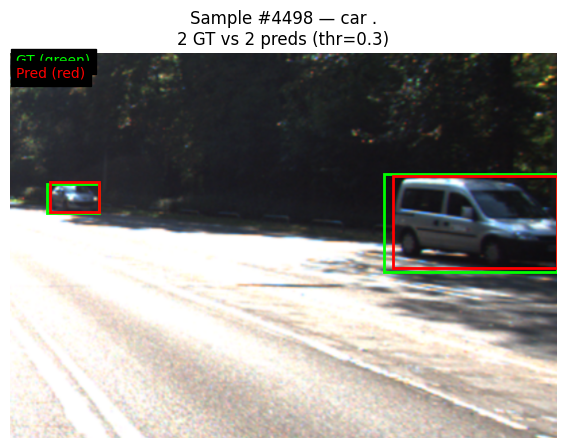

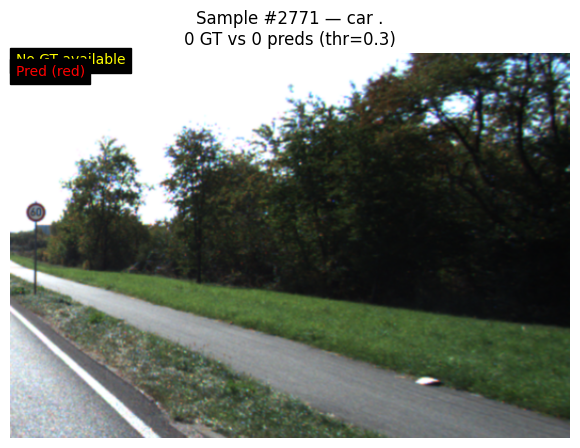

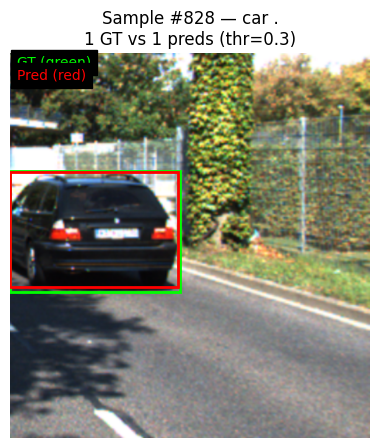

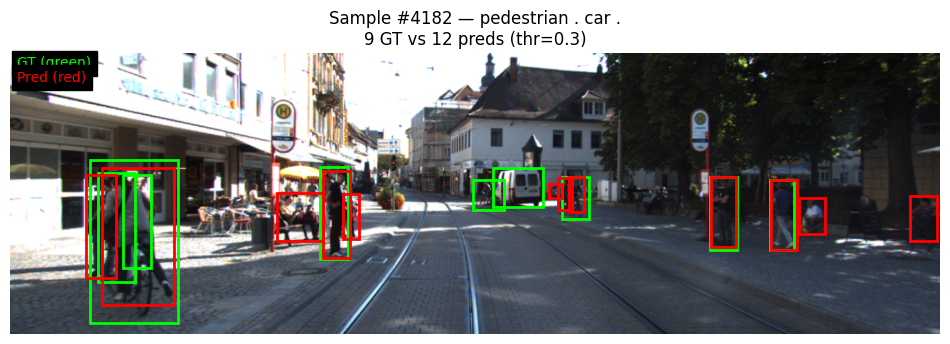

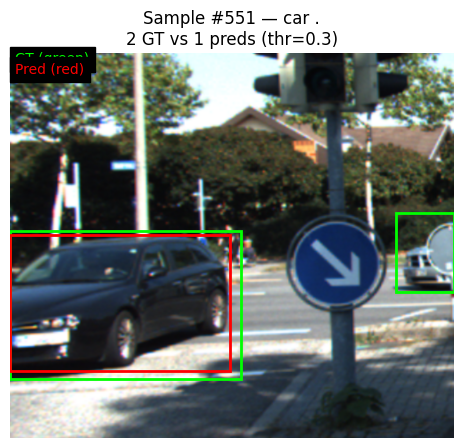

In [30]:
visualize_detections(model, postprocessors, dataset, num_samples=5, device=args.device)


In [19]:
sample, target = dataset[0]

img = sample.tensors[0] if hasattr(sample, "tensors") else sample
print("dtype:", img.dtype, "min:", img.min().item(), "max:", img.max().item(), "mean:", img.mean().item())


dtype: torch.float32 min: -2.015155553817749 max: 2.640000104904175 mean: -0.6432046294212341


In [23]:
sample, target = dataset[3766]
print("GT shape:", target["boxes"].shape)
print(target["boxes"])


GT shape: torch.Size([12, 4])
tensor([[0.4121, 0.4969, 0.0177, 0.0423],
        [0.5656, 0.5142, 0.0669, 0.0988],
        [0.5814, 0.5304, 0.0804, 0.1258],
        [0.5975, 0.5424, 0.0943, 0.1311],
        [0.5773, 0.5193, 0.0743, 0.1019],
        [0.0733, 0.6259, 0.1466, 0.2216],
        [0.4416, 0.4990, 0.0142, 0.0359],
        [0.6353, 0.5500, 0.1105, 0.1647],
        [0.1818, 0.5741, 0.1163, 0.1712],
        [0.4956, 0.5275, 0.0341, 0.1067],
        [0.5278, 0.4861, 0.0350, 0.0514],
        [0.6550, 0.5635, 0.1189, 0.2046]])


In [28]:
sample, target = dataset[2747]
print(target["boxes"])


tensor([], size=(0, 4))


usage: ipykernel_launcher.py [-h] --root ROOT --odvg ODVG [--num NUM]
ipykernel_launcher.py: error: the following arguments are required: --root, --odvg


SystemExit: 2

/isis/home/hasana3/miniconda3/envs/dino_train/lib/python3.10/site-packages/IPython/core/interactiveshell.py:3585: UserWarning: To exit: use 'exit', 'quit', or Ctrl-D.
  warn("To exit: use 'exit', 'quit', or Ctrl-D.", stacklevel=1)


In [36]:
import os
import jsonlines
import random
import matplotlib.pyplot as plt
import cv2

# ==== UPDATE THESE TWO PATHS ====
KITTI_ROOT = "/isis/home/hasana3/vlmtest/GroundingDINO/dataset/kitti/training"
ODVG_FILE = "/isis/home/hasana3/vlmtest/GroundingDINO/dataset/kitti/training/kitti_odvg2.jsonl"
# =================================

def load_kitti_gt(gt_file):
    """Load KITTI txt GT (tracking). Returns list of (x1,y1,x2,y2,label)."""
    gts = []
    with open(gt_file, "r") as f:
        for line in f:
            parts = line.strip().split()
            if len(parts) < 10:
                continue

            cls = parts[2]

            # Strict filtering rules:
            if cls in ["Car", "Van", "Truck"]:
                label = "car"
            elif cls == "Pedestrian":
                label = "pedestrian"
            else:
                continue  # Excludes Person_sitting, Cyclist, etc.

            x1, y1, x2, y2 = map(float, parts[6:10])
            gts.append((x1, y1, x2, y2, label))
    return gts


def load_odvg(jsonl_path):
    """Load ODVG JSONL → dict: { '0000/000001.png': [(x1,y1,x2,y2,label), ...] }"""
    data = {}
    with jsonlines.open(jsonl_path) as reader:
        for obj in reader:
            fname = obj["filename"]
            entries = []
            for r in obj["detection"]["instances"]:
                x1, y1, x2, y2 = r["bbox"]
                entries.append((x1, y1, x2, y2, r["phrase"]))
            data[fname] = entries
    return data


def show_frame(fname, kitti_boxes, odvg_boxes):
    seq, imgname = fname.split("/")
    img_path = os.path.join(KITTI_ROOT, "image_02", seq, imgname)

    img = cv2.imread(img_path)
    if img is None:
        print("❌ Image not found:", img_path)
        return

    img_kitti = img.copy()
    img_odvg = img.copy()

    # Draw KITTI GT in Blue
    for (x1, y1, x2, y2, lab) in kitti_boxes:
        cv2.rectangle(img_kitti, (int(x1), int(y1)), (int(x2), int(y2)), (255, 0, 0), 2)
        cv2.putText(img_kitti, lab, (int(x1), int(y1)-3),
                    cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255,0,0), 2)

    # Draw ODVG GT in Green
    for (x1, y1, x2, y2, lab) in odvg_boxes:
        cv2.rectangle(img_odvg, (int(x1), int(y1)), (int(x2), int(y2)), (0, 255, 0), 2)
        cv2.putText(img_odvg, lab, (int(x1), int(y1)-3),
                    cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0,255,0), 2)

    # Plot side-by-side
    fig, axs = plt.subplots(1, 2, figsize=(14, 7))
    axs[0].set_title("Original KITTI GT (Blue)")
    axs[0].imshow(cv2.cvtColor(img_kitti, cv2.COLOR_BGR2RGB))
    axs[0].axis("off")

    axs[1].set_title("ODVG GT (Green)")
    axs[1].imshow(cv2.cvtColor(img_odvg, cv2.COLOR_BGR2RGB))
    axs[1].axis("off")

    plt.show()


# Load ODVG once
odvg_data = load_odvg(ODVG_FILE)
print(f"Loaded {len(odvg_data)} ODVG frames ✅")



KeyError: 'detection'